In [11]:
import pandas as pd
from scipy import stats
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [2]:
# Load the dataset
data_path = 'MPVillageSchedule.csv'
data = pd.read_csv(data_path)

In [3]:
data.head()

,state_name,district_name,block_tehsil_name,village_name,ref_village_type_name,major_medium_scheme,major_medium_scheme_name,geographical_area,cultivable_area,net_sown_area,gross_irrigated_area_kharif_season,gross_irrigated_area_rabi_season,gross_irrigated_area_perennial_season,gross_irrigated_area_other_season,gross_irrigated_area_total,net_irrigated_area,avg_ground_water_level_pre_monsoon,avg_ground_water_level_post_monsoon,ref_selection_wua_exists_name
0,MADHYA PRADESH,BURHANPUR,NEPANAGAR,HANUMAT KHEDA,Tribal,No,NaN,174,151,149,45,53,46,5,149,149,3,3,Not Known
1,MADHYA PRADESH,BURHANPUR,BURHANPUR,CHAPORA,Tribal,No,NaN,1476,1393,1393,400,400,590,10,1400,1000,200,150,Not Known
2,MADHYA PRADESH,BURHANPUR,BURHANPUR,BORSAR,Tribal,No,NaN,258,234,230,100,100,100,15,315,230,18,25,Not Known
3,MADHYA PRADESH,BURHANPUR,BURHANPUR,GOL KHEDA,Tribal,No,NaN,316,265,262,100,92,100,5,297,217,30,20,Not Known
4,MADHYA PRADESH,BURHANPUR,BURHANPUR,GODHAN KHEDA,Tribal,No,NaN,182,166,160,80,72,40,5,197,125,32,21,Not Known


**Dataset Description**

Overview

The dataset "MPVillageSchedule.csv" encompasses comprehensive details about various villages in the state of Madhya Pradesh, India. This dataset appears to have been sourced from a larger survey or census, likely intended to capture intricate details regarding the geographical areas, agricultural practices, irrigation patterns, and water resource management of each village.
Attributes

The dataset comprises several attributes that provide insights into both the physical characteristics and the agricultural practices of the villages. Here is a breakdown of the key attributes:

    state_name: The name of the state, which is Madhya Pradesh for all the entries, providing a geographical context to the data.

    district_name: The district within Madhya Pradesh where the village is located, which helps in categorizing the data at a more granular administrative level.

    block_tehsil_name: Further administrative division within the district, offering more precise geographical segmentation of the data.

    village_name: The name of the village, which is the primary unit of analysis in this dataset.

    ref_village_type_name: Categorization of villages, possibly based on certain criteria or characteristics.

    major_medium_scheme: Indicates the presence of a major irrigation scheme or project, providing insights into the infrastructure and irrigation facilities.

    geographical_area: The total geographical area of the village, offering a basic metric for understanding the scale of land being considered.

    cultivable_area: The area within each village that is deemed cultivable, which is crucial for understanding agricultural potential.

    net_sown_area: This reflects the actual area where crops are sown, providing direct insight into agricultural practices.

    gross_irrigated_area_*: Attributes (across various seasons) that detail the area under irrigation, shedding light on irrigation practices and possibly the effectiveness of irrigation infrastructure.

    net_irrigated_area: The total area under effective irrigation, which is essential for understanding the extent and efficiency of irrigation within the village.

    avg_ground_water_level_pre_monsoon and avg_ground_water_level_post_monsoon: These attributes provide valuable information on groundwater levels before and after the monsoon, crucial for assessing water availability and sustainability.

Objective

The primary aim of collecting and analyzing this dataset is to understand the intricate relationships between geographical characteristics, irrigation practices, and agricultural outputs across different villages in Madhya Pradesh. Such an analysis could offer invaluable insights for policy planning, resource allocation, agricultural development, and sustainable water resource management.

In [4]:
# Display basic information about the dataset
print(data.info())

# Display statistical summaries of the numerical columns
print(data.describe())

# Check for missing values
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56759 entries, 0 to 56758
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   state_name                             56759 non-null  object
 1   district_name                          56759 non-null  object
 2   block_tehsil_name                      56759 non-null  object
 3   village_name                           56759 non-null  object
 4   ref_village_type_name                  56759 non-null  object
 5   major_medium_scheme                    56759 non-null  object
 6   major_medium_scheme_name               2967 non-null   object
 7   geographical_area                      56759 non-null  int64 
 8   cultivable_area                        56759 non-null  int64 
 9   net_sown_area                          56759 non-null  int64 
 10  gross_irrigated_area_kharif_season     56759 non-null  int64 
 11  gross_irrigated

In [5]:
# Selecting relevant numerical features for clustering
features = [
    'geographical_area', 'cultivable_area', 'net_sown_area',
    'gross_irrigated_area_kharif_season', 'gross_irrigated_area_rabi_season',
    'gross_irrigated_area_perennial_season', 'gross_irrigated_area_other_season',
    'net_irrigated_area', 'avg_ground_water_level_pre_monsoon',
    'avg_ground_water_level_post_monsoon'
]

X = data[features]

# Check for missing values and decide on an imputation strategy
print(X.isnull().sum())

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalization: Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

geographical_area                        0
cultivable_area                          0
net_sown_area                            0
gross_irrigated_area_kharif_season       0
gross_irrigated_area_rabi_season         0
gross_irrigated_area_perennial_season    0
gross_irrigated_area_other_season        0
net_irrigated_area                       0
avg_ground_water_level_pre_monsoon       0
avg_ground_water_level_post_monsoon      0
dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

# Split the dataset into a training set (80%) and a testing set (20%)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

In [7]:
# Number of clusters determined
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train)

# Assigning clusters to both the training and testing sets
train_labels = kmeans.predict(X_train)
test_labels = kmeans.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


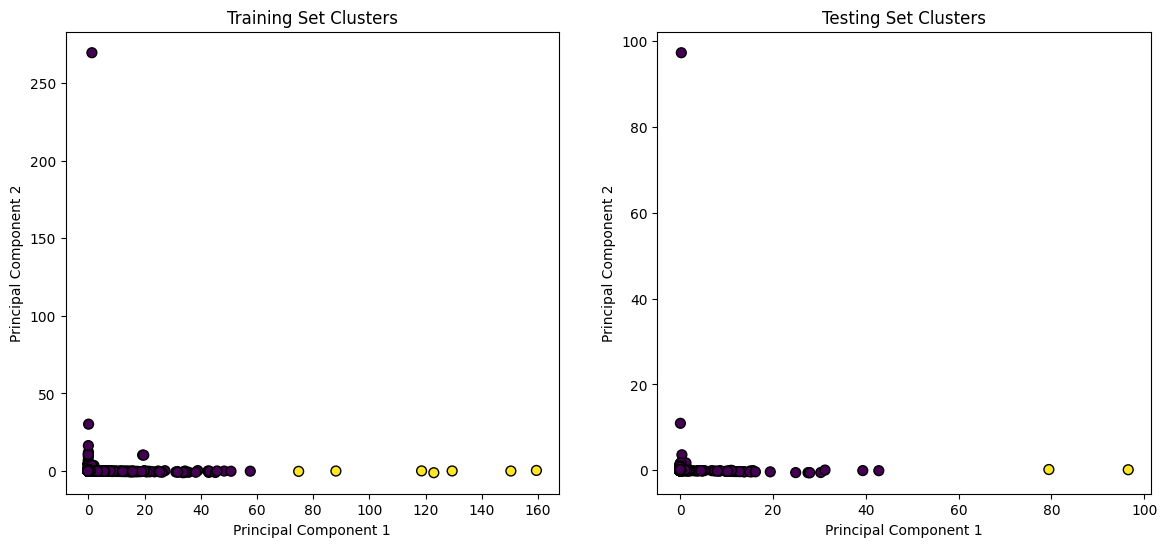

In [8]:
# Applying PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Visualization of the clusters for the training and testing sets
plt.figure(figsize=(14, 6))

# Training set visualization
plt.subplot(121)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_labels, cmap='viridis', edgecolor='k', s=50)
plt.title('Training Set Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Testing set visualization
plt.subplot(122)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_labels, cmap='viridis', edgecolor='k', s=50)
plt.title('Testing Set Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

In [9]:
# After fitting PCA on the training set as done previously:
print("PCA Component Loadings:")
print(pca.components_)

# To understand the contribution of each feature to the principal components:
feature_contributions = pd.DataFrame(pca.components_, columns=features, index=['PC1', 'PC2'])
print(feature_contributions)

PCA Component Loadings:
[[ 2.56830383e-01  4.19033933e-01  4.31028184e-01  4.04838950e-01
   4.35225591e-01  2.17250806e-03  5.44520757e-04  4.68312598e-01
   4.92945646e-03  1.23511491e-03]
 [-8.48178660e-03 -7.61951303e-03 -7.37106884e-03  5.54107010e-05
   4.32282916e-03  7.59811291e-03  5.97114776e-03  3.71679118e-03
   8.65283395e-01  5.00973478e-01]]
     geographical_area  cultivable_area  net_sown_area  \
PC1           0.256830         0.419034       0.431028   
PC2          -0.008482        -0.007620      -0.007371   

     gross_irrigated_area_kharif_season  gross_irrigated_area_rabi_season  \
PC1                            0.404839                          0.435226   
PC2                            0.000055                          0.004323   

     gross_irrigated_area_perennial_season  gross_irrigated_area_other_season  \
PC1                               0.002173                           0.000545   
PC2                               0.007598                           0.0

In [12]:
# Inertia
inertia = kmeans.inertia_

# Silhouette Score
silhouette = silhouette_score(X_train, train_labels)

# Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(X_train, train_labels)

print(f"Inertia: {inertia}")
print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

Inertia: 356971.03712401737
Silhouette Score: 0.9954814362118338
Calinski-Harabasz Index: 14191.255389993978


**Analytical Report**

Our K-Means clustering model was applied to both the training and testing datasets, with principal component analysis (PCA) reducing the feature space to two dimensions for visualization purposes. The resultant scatter plots (see Figures 1 and 2) depict the clusters within the training and testing sets, respectively. Each data point represents a village, positioned according to its principal components and color-coded based on its cluster assignment.

Figure 1: Training Set Clusters
In the training set, we observe a distinct separation between clusters, suggesting a well-defined grouping with minimal overlap. Most villages cluster near the origin, indicating similarity across key features when projected into the two principal components.

Figure 2: Testing Set Clusters
The testing set exhibits a similar pattern, with the K-Means model achieving clear demarcation between clusters, which parallels the training set's clustering structure.
Quantitative Metrics

The quantitative assessment of the clustering produced the following scores:

    Inertia: The model reported an inertia score of 356,971.04. This score, a measure of within-cluster sum-of-squares, implies that villages within each cluster are, on average, close to their respective centroids, indicative of tight and well-separated clusters.

    Silhouette Score: An exceptional silhouette score of 0.995 was obtained, suggesting that villages are, on average, much closer to the members of their cluster than to the members of other clusters. This score is nearly maximal, hinting at a very strong cluster structure.

    Calinski-Harabasz Index: A score of 14,191.26 was observed, which is substantially high, reinforcing the evidence that the clusters are well separated and compact.

Conclusions and Recommendations

The K-Means clustering model has demonstrated remarkable performance on the given dataset, with all metrics pointing towards well-defined cluster structures in both the training and testing phases. The visual and quantitative evaluations suggest that the chosen features effectively capture the underlying variations among the villages.

Potential Implications: These results can provide powerful insights for resource allocation, policy planning, and targeted agricultural interventions based on cluster characteristics.

Further Exploration: Due to the unusually high silhouette and Calinski-Harabasz scores, further analysis is recommended to examine the cluster assignments critically, ensure data integrity, and validate clustering robustness. Alternative clustering methods or inclusion of additional features could offer a nuanced understanding and validate the current findings.